In [14]:
import glob
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.datagenerator import DataGenerator, DataLoader, z_score
from src.performance_evaluation import compute_PCA, plot_confusion_matrix, plot_PCA
from src.util import plot_voxel
from src.performance_evaluation import (
    compute_position_error,
    compute_volume_error,
)

# load vae model
from src.vae import vae_model

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
print(tf.__version__)

2.16.1


# Stage 2

**1. Training of the material classificator $\Upsilon$**

**2. Training of the mapper $\Xi$**

## Material classificator $\Upsilon$

**CNN**

In [ ]:
datagenerator = False

params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": True,
    "EIT_shape": "matrix",
}

if datagenerator:
    idx = np.arange(0, len(os.listdir(params["path"])))
    np.random.shuffle(idx)

    limit_index = 100_000

    training_generator = DataGenerator(idx[:limit_index], **params)
    test_____generator = DataGenerator(idx[limit_index:], **params)
    X, Y = training_generator[0]
else:
    X, Y = DataLoader(params)
    X = z_score(X)
    X = np.expand_dims(X, axis=3)
    print(X.shape, Y.shape)

In [ ]:
print(X.shape, Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42
)

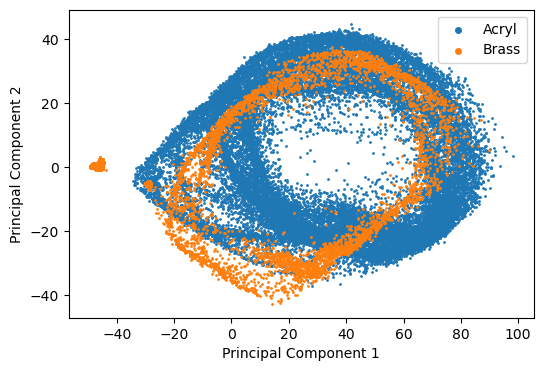

In [6]:
data_pca = compute_PCA(X_train)
plot_PCA(data_pca, Y_train)

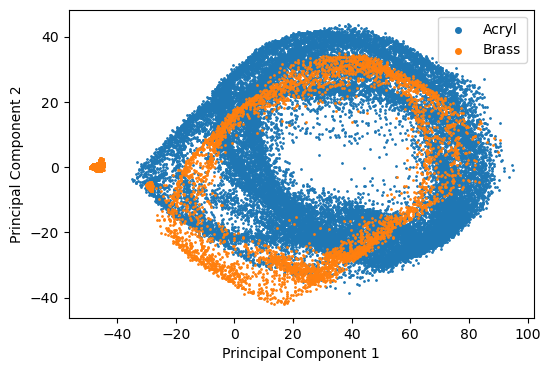

In [7]:
data_pca = compute_PCA(X_test)
plot_PCA(data_pca, Y_test)

In [8]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(62100, 64, 64, 1) (62100, 64, 64, 1) (62100,) (62100,)


In [9]:
def material_classificator_model_CNN(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    # optional aditional layer
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    mapper_input = tf.keras.layers.Input(shape=input_shape)
    # normalize input data
    # x = Xscaler(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


material_classificator_CNN = material_classificator_model_CNN()
material_classificator_CNN.summary()

2024-05-14 09:49:16.009484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46873 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
material_classificator_CNN.compile(tf.optimizers.Adam(learning_rate=0.005), loss="mse")

In [11]:
if datagenerator:
    classificator_history_CNN = material_classificator_CNN.fit(
        training_generator, epochs=50, batch_size=128
    )
else:
    classificator_history_CNN = material_classificator_CNN.fit(
        X_train,
        Y_train,
        epochs=20,
        batch_size=params["batch_size"],
    )

material_classificator_CNN.save_weights("models/material_mapper.weights.h5")

Epoch 1/20


I0000 00:00:1715680158.116420  352067 service.cc:145] XLA service 0x7f0e6400b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715680158.116472  352067 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-05-14 09:49:18.223483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 09:49:18.369014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 93/486 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1093

I0000 00:00:1715680159.552063  352067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0416
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1669e-04
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6511e-04
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7709e-04
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010
Epoch 12/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7167e-04
Epoch 13/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5532e-04
Epoch 14/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7110e-04
Epoch 15/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 

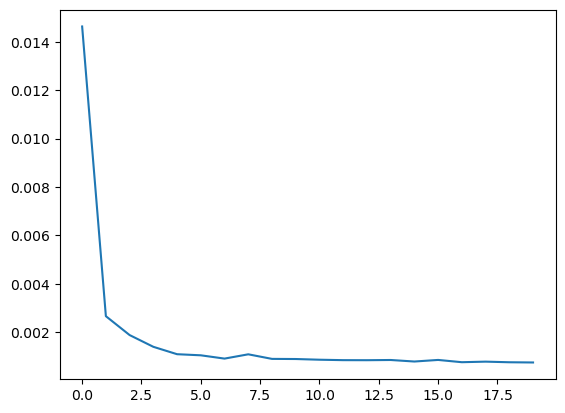

In [12]:
plt.plot(classificator_history_CNN.history["loss"])

In [11]:
Y_pred = np.concatenate(np.round(material_classificator_CNN.predict(X_test)))

1941/1941 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [12]:
s_path = "models/mapper_4/"

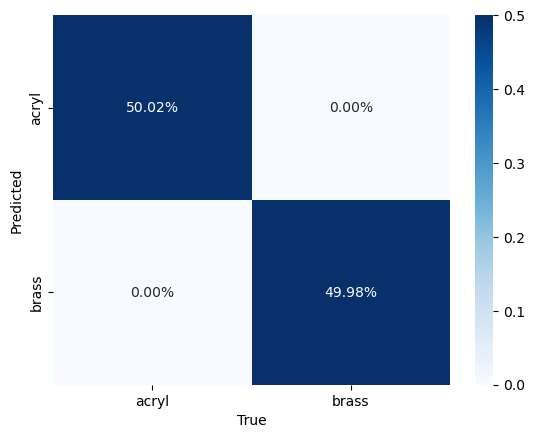

In [13]:
plot_confusion_matrix(Y_test, np.abs(Y_pred), s_path)

In [47]:
# os.mkdir(s_path)
material_classificator_CNN.save(f"{s_path}/model.keras")
np.savez(s_path + "/test_data.npz", X_test=X_test, Y_test=Y_test, params=params)

## Mapper $\Xi$

Loat the VAE model and train the two required mapper.

In [15]:
vae = vae_model()
vae.load_weights("models/vaes/vae_21.weights.h5")
vae.summary()

Φ = vae.encoder
Ψ = vae.decoder

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        13,662 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        17,933 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,595 (123.42 KB)

 Trainable params: 31,533 (123.18 KB)

 Non-trainable params: 62 (248.00 B)

In [4]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "EIT_shape": "matrix",
    "supervised": "anomaly_and_material",  # "diameter", "material", "anomaly", "anomaly_and_material"
    "batch_size": 128,
    "shuffle": False,
}

In [5]:
X, Y, m = DataLoader(params)

X = z_score(X)
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=4)

100%|██████████| 124200/124200 [50:16<00:00, 41.17it/s] 


In [10]:
X_train, X_test, gamma_train, gamma_test, m_train, m_test = train_test_split(
    X, Y, m, test_size=0.1, random_state=42
)
# del X,Y,m

In [ ]:
_, _, z_train = Φ.predict(gamma_train)

In [ ]:
_, _, z_test = Φ.predict(gamma_test)

In [254]:
print(X_train.shape, gamma_train.shape, m_train.shape, z_train.shape)
print(X_test.shape, gamma_test.shape, m_test.shape, z_test.shape)

(111780, 64, 64, 1) (111780, 32, 32, 32, 1) (111780,) (111780, 8)
(12420, 64, 64, 1) (12420, 32, 32, 32, 1) (12420,) (12420, 8)


In [455]:
tmp = np.load("models/mappers/predictable_model_10.npz", allow_pickle=True)
print(f"{tmp['precision']:.2f}")

90.06


In [441]:
# |---------------------- HPT#1 --------------------- with VAE model = 17-------------------------------------------------------------|
# | model  a1: e = 50 , bs = 16, filters=[2,  4,  8, 16], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=55.06 %|
# | model  a2: e = 75 , bs = 16, filters=[4,  8, 16, 32], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=50.93 %|
# | model  a3: e = 75 , bs = 16, filters=[4,  8,  8, 16], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=56.12 %|
# | model  a4: e = 75 , bs = 16, filters=[8,  8,  8, 16], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=61.84 %|
# | model  a5: e = 75 , bs = 16, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=58.16 %|

# | model  a6: e = 75 , bs =  8, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=77.92 %|
# | model  a7: e = 75 , bs =  8, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=67.13 %|
# | model  a8: e = 75 , bs =  8, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=64.90 %|
# | model  a9: e = 75 , bs =  8, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mae, predictable=62.13 %|
# | model a10: e = 75 , bs =  4, filters=[8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mae, predictable=55.17 %|
# |-----------------------------------------------------------------------------------------------------------------------------------|

# Changed the VAE because of the discovery of a better generalized version.
# ... continue with the best prediction performance of HPT#1 -> model configuration 6.

# |--------------------- HPT#2 -----------------------with VAE model = 21-------------------------------------------------------------|
# | model  1: e = 75 , bs =  8, filters=[ 8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=92.19 %|
# | model  2: e = 75 , bs =  6, filters=[ 8, 16, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=90.94 %|
# | model  3: e = 75 , bs =  8, filters=[16, 32, 32, 64], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=92.09 %|
# | model  4: e = 75 , bs =  8, filters=[8, 32, 64, 128], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable=92.77 %|
# | model  5: e = 75 , bs =  8, filters=[8, 32, 64, 128], kernels(2, 2), strides=(1, 1), pools=(2, 2), loss = mse, predictable=54.65 %|

# | model  6: e = 75 , bs =  8, filters=[4, 8, 16, 32], kernels(2, 2), strides=(1, 1), pools=(2, 2), loss = mse, predictable = 92.54 %|
# | model  7: e = 75 , bs =  6, filters=[4, 8, 16, 32], kernels(4, 4), strides=(1, 1), pools=(2, 2), loss = mse, predictable = 92.58 %|
# | model  8: e = 75 , bs =  5, filters=[4, 8, 16, 32], kernels(4, 4), strides=(1, 1), pools=(2, 2), loss = mse, predictable = 96.01 %|
# | model  9: e = 75 , bs =  16,filters=[4, 8, 16, 32], kernels(4, 4), strides=(1, 1), pools=(2, 2), loss = mse, predictable = 90.83 %|
# | model 10: e = 75 , bs =  5, filters=[4, 8, 16, 32], kernels(3, 3), strides=(1, 1), pools=(2, 2), loss = mse, predictable = 90.06 %|
# |-----------------------------------------------------------------------------------------------------------------------------------|

epochs = 75
batch_size = 5


def mapper_CNN(input_shape=(64, 64, 1), latent_dim=8):
    filters = [4, 8, 16, 32]
    kernels = [(3, 3) for _ in range(4)]
    strides = [(1, 1) for _ in range(4)]
    pools = [(2, 2) for _ in range(4)]

    print(f"{filters=}, kernels{kernels[0]}, strides={strides[0]}, pools={pools[0]}")

    x = tf.keras.layers.Input(shape=input_shape)
    mapper_input = x

    for f, k, s, p in zip(filters, kernels, strides, pools):
        x = tf.keras.layers.Conv2D(
            filters=f, kernel_size=k, strides=s, padding="valid", activation="relu"
        )(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=p)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(latent_dim, activation="relu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim)(x)

    return tf.keras.Model(mapper_input, mapper_output)


Ξ = mapper_CNN()
# losses to try:
# mean_squared_logarithmic_error
# mean_absolute_percentage_error
Ξ.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
Ξ.summary()

filters=[4, 8, 16, 32], kernels(3, 3), strides=(1, 1), pools=(2, 2)


Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_59 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_209 (Conv2D)             │ (None, 62, 62, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_203               │ (None, 31, 31, 4)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_210 (Conv2D)             │ (None, 29, 29, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_204               │ (None, 14, 14, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_211 (Conv2D)             │ (None, 12, 12, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_205               │ (None, 6, 6, 16)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_212 (Conv2D)             │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_206               │ (None, 2, 2, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_54 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 8)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,248 (28.31 KB)

 Trainable params: 7,248 (28.31 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(f"{batch_size=}, {epochs=}")
history = Ξ.fit(X_train, z_train, batch_size=batch_size, epochs=epochs)

batch_size=5, epochs=75
Epoch 1/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0838
Epoch 2/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0449
Epoch 3/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0389
Epoch 4/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0342
Epoch 5/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0322
Epoch 6/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0311
Epoch 7/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0304
Epoch 8/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0299
Epoch 9/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0293
Epoch 10/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0290
Epoch 11/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0285
Epoch 12/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0283
Epoch 13/75
22356/22356 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - loss: 0.0280
Epoch 14/75
22356/22356 ━━━━━━━━━━━━

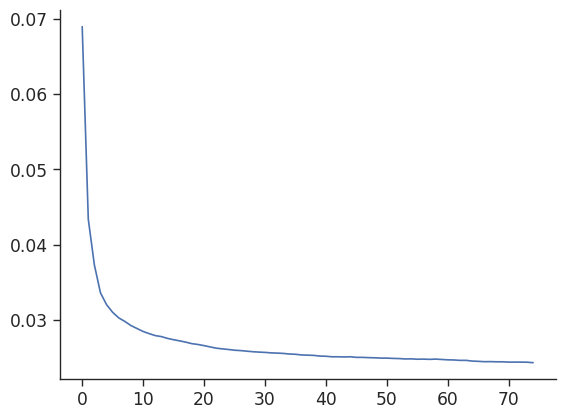

In [456]:
plt.plot(history.history["loss"], label=keys)
plt.show()

**Test the mapper $\Xi$ performance**

The variable `γ_hat` represents $\hat{\gamma}$, which is the reconstructed conductivity distribution.
It is generated by:
$$\hat{\gamma} = \Psi(\Xi(\mathbf{u})) = \Psi \circ \Xi :  \mathbf{u} \mapsto \mathbf{z} \mapsto \hat{\gamma} $$

In [457]:
γ_hat = Ψ.predict(Ξ.predict(X_test))
γ_hat = np.squeeze(γ_hat, axis=4)
γ_hat = np.clip(γ_hat, a_min=0, a_max=1)
γ_hat[γ_hat != 0] = 1
print(γ_hat.shape)

389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(12420, 32, 32, 32)


True γ distribution


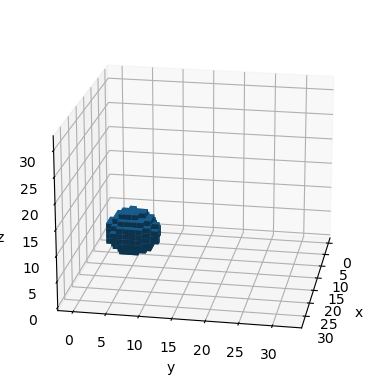

Predicted γ distribution


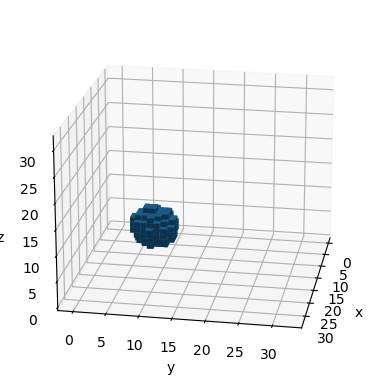

---------
True γ distribution


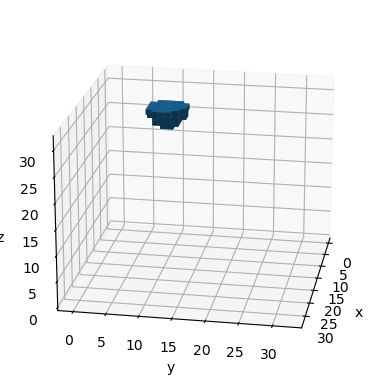

Predicted γ distribution


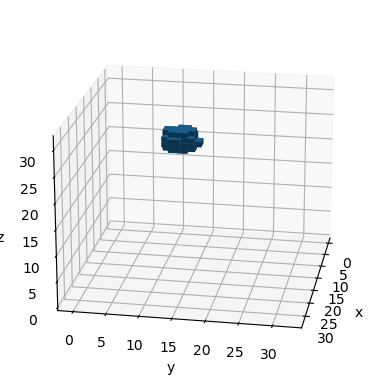

---------
True γ distribution


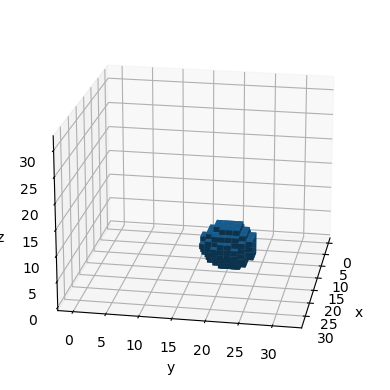

Predicted γ distribution


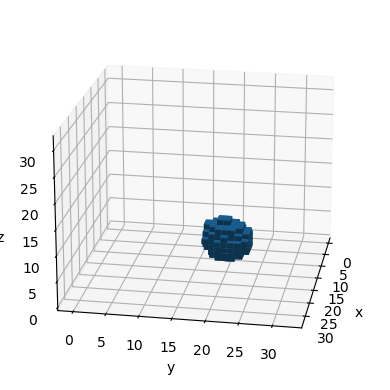

---------
True γ distribution


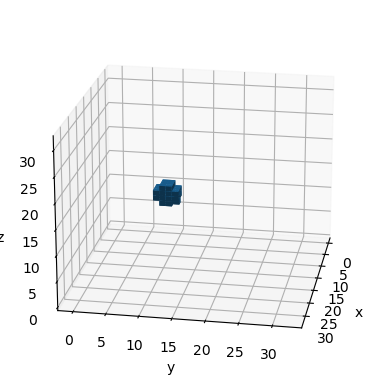

Predicted γ distribution


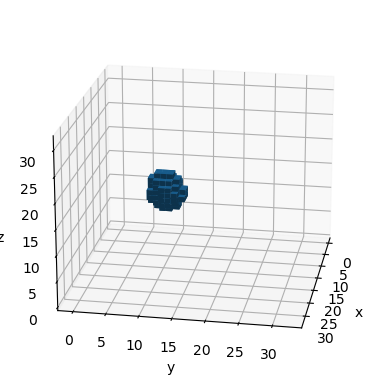

---------
True γ distribution


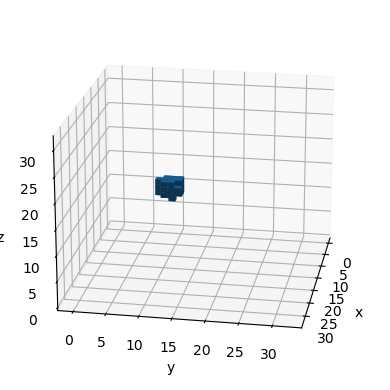

Predicted γ distribution


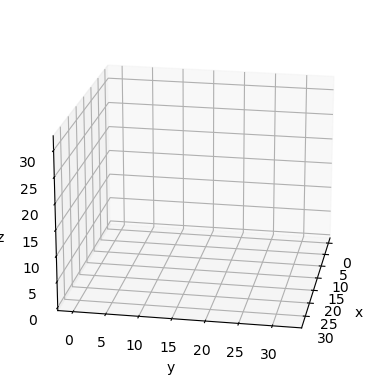

---------


In [458]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=γ_hat.shape[0], size=5):
    print("True γ distribution")
    plot_voxel(gamma_test[rdn, :, :, :, 0])
    print("Predicted γ distribution")
    plot_voxel(γ_hat[rdn])
    print("---------")

In [ ]:
mapper_idx = len(glob.glob("models/mappers/*.h5")) + 1
mapper_idx

In [459]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list(), test_idx=list())

data_append = []

for idx, v_err in enumerate(compute_volume_error(γ_hat, gamma_test)):
    if v_err != None:
        v_percent = (v_err / 32**3) * 100
        data_append.append(
            dict(Model=mapper_idx, Error_val=v_percent, Error="Volume", test_idx=idx)
        )

for idx, p_err in enumerate(compute_position_error(gamma_test, γ_hat)):
    if p_err != None:
        p_percent = (p_err / np.linalg.norm(np.array([32, 32, 32]))) * 100
        data_append.append(
            dict(Model=mapper_idx, Error_val=p_percent, Error="Position", test_idx=idx)
        )

# Create dictionary
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

In [460]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(
    f"models/mappers/mappers_acc_measure_{mapper_idx}.csv", index=False
)
acc_measure_df

,Model,Error_val,Error,test_idx
0,10,-0.192261,Volume,0
1,10,0.067139,Volume,1
2,10,0.344849,Volume,2
3,10,-0.064087,Volume,3
4,10,0.219727,Volume,4
...,...,...,...,...
22367,10,2.003676,Position,12415
22368,10,1.651472,Position,12416
22369,10,1.653277,Position,12417
22370,10,3.484440,Position,12418


Text(0, 0.5, 'Error (%)')

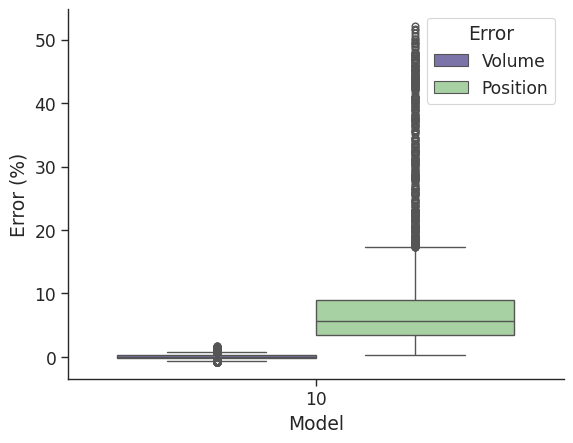

In [461]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)
custom_palette = ["#756bb1", "#a1d99b"]
sns.boxplot(
    x="Model",
    y="Error_val",
    data=acc_measure_df,
    hue="Error",
    showfliers=True,
    palette=custom_palette,
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

In [ ]:
Ξ.save_weights(f"models/mappers/mapper_{mapper_idx}.weights.h5")

In [462]:
# CHECK HOW MUCH TEST DATA CAN (NOT) BE PREDICTED!
volume_preds = len([True for ele in acc_measure_df["Error"] if ele == "Volume"])
position_preds = len([True for ele in acc_measure_df["Error"] if ele == "Position"])
print("Length condition is:", np.allclose(volume_preds, position_preds))
precision = volume_preds / gamma_test.shape[0] * 100
print(f"Copy this to the top hpt entry:\n {precision:.2f}%")
np.savez(
    f"models/mappers/predictable_model_{mapper_idx}.npz",
    precision=precision,
)

Length condition is: True
Copy this to the top hpt entry:
 90.06%


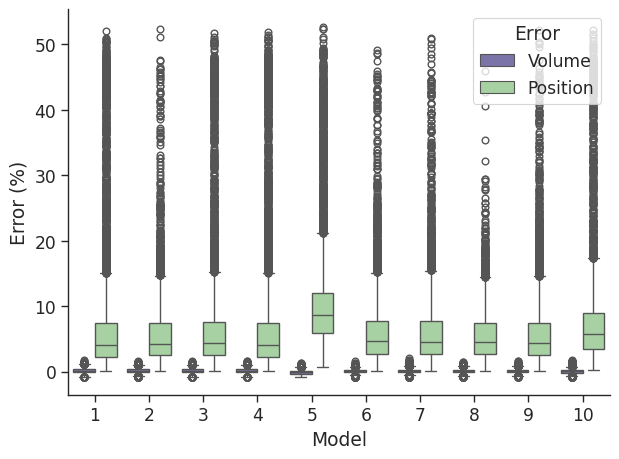

In [463]:
# Load all CSV files and concatenate them
# plt.style.use('default')

combined_df = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in glob.glob("models/mappers/mappers_acc_measure_*.csv")
    ],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)
# combined_df.to_csv(f"models/mappers/all_measures.csv", index=False)
custom_palette = ["#756bb1", "#a1d99b"]
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=True,
    palette=custom_palette,
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
plt.tight_layout()
# plt.savefig("images/vae_hpt.pdf")
plt.show()